# Experiment 2: Content/Motion Swapping ⭐

**This is a KEY experiment demonstrating the disentanglement capability.**

The goal is to show that we can:
1. Take content (digit identity) from Video A
2. Take motion (trajectory) from Video B
3. Generate a new video with A's digit moving like B

This is ONLY possible with the Disentangled VAE architecture!


In [1]:
import sys
sys.path.insert(0, '..')

import torch
import numpy as np
import matplotlib.pyplot as plt
import os

from data import get_moving_mnist_dataloaders, MovingMNISTWithLabels
from models import DisentangledVAE
from utils import plot_swap_results, plot_video_frames, create_comparison_animation

# Set device
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")


Using device: mps


## 1. Load Model and Data


In [2]:
# Load the Disentangled VAE model
model = DisentangledVAE(content_dim=128, motion_dim=128).to(device)

checkpoint_path = '../checkpoints/disentangled_vae/best_model.pt'
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("✓ Loaded model from checkpoint")
else:
    print("✗ No checkpoint found! Please train the model first.")
    print("Run: python -m training.train --model disentangled --name disentangled_vae")


✓ Loaded model from checkpoint


In [3]:
# Create dataset with labels for controlled experiments
dataset = MovingMNISTWithLabels(
    num_videos=500,
    sequence_length=20,
    frame_size=64,
    num_digits=2,
    deterministic=True,
    seed=42
)

# Get test loader
_, _, test_loader = get_moving_mnist_dataloaders(
    batch_size=16,
    train_size=100,
    val_size=50,
    test_size=200,
    num_workers=0,
    seed=42,
    with_labels=True
)
print(f"Test samples: {len(test_loader.dataset)}")


Test samples: 200


## 2. Content Swap Experiments

We take content from Video A and motion from Video B to create a new video.



--- Swap 1 ---
Content source digits: [np.int64(2), np.int64(6)]
Motion source digits: [np.int64(2), np.int64(5)]
Expected result: Content source digits moving like motion source


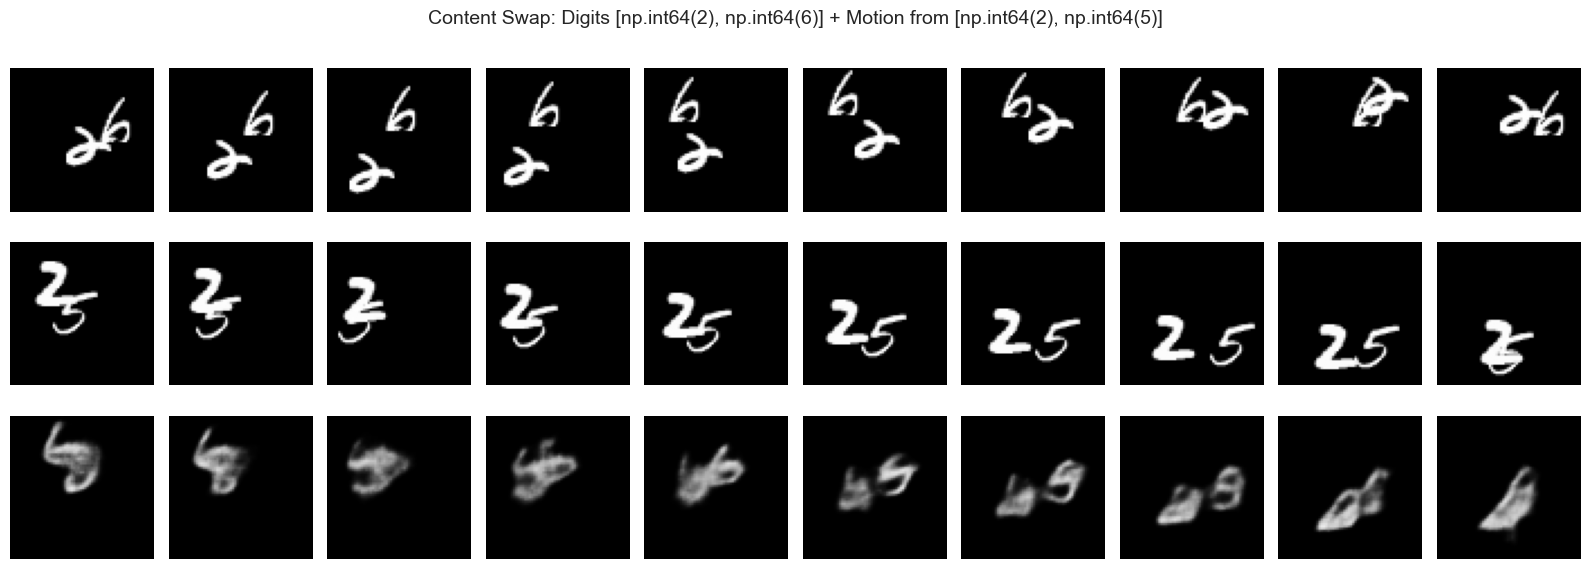


--- Swap 2 ---
Content source digits: [np.int64(1), np.int64(6)]
Motion source digits: [np.int64(0), np.int64(1)]
Expected result: Content source digits moving like motion source


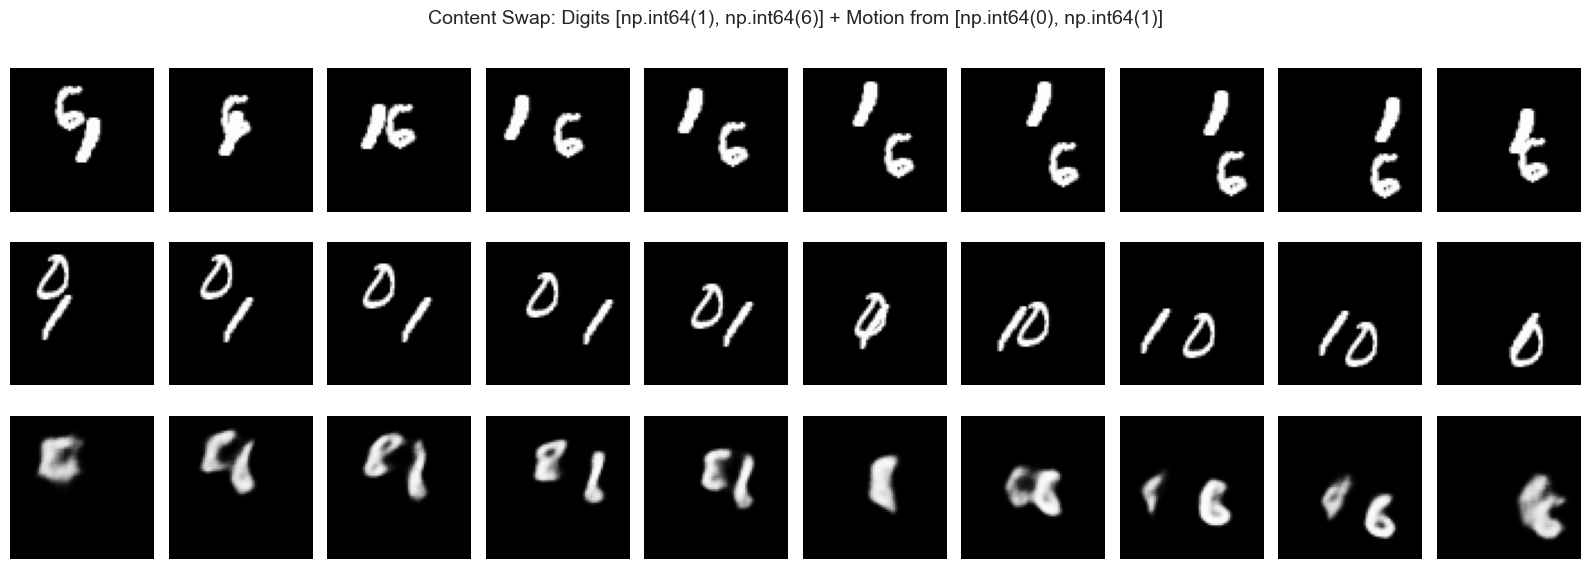


--- Swap 3 ---
Content source digits: [np.int64(1), np.int64(3)]
Motion source digits: [np.int64(0), np.int64(5)]
Expected result: Content source digits moving like motion source


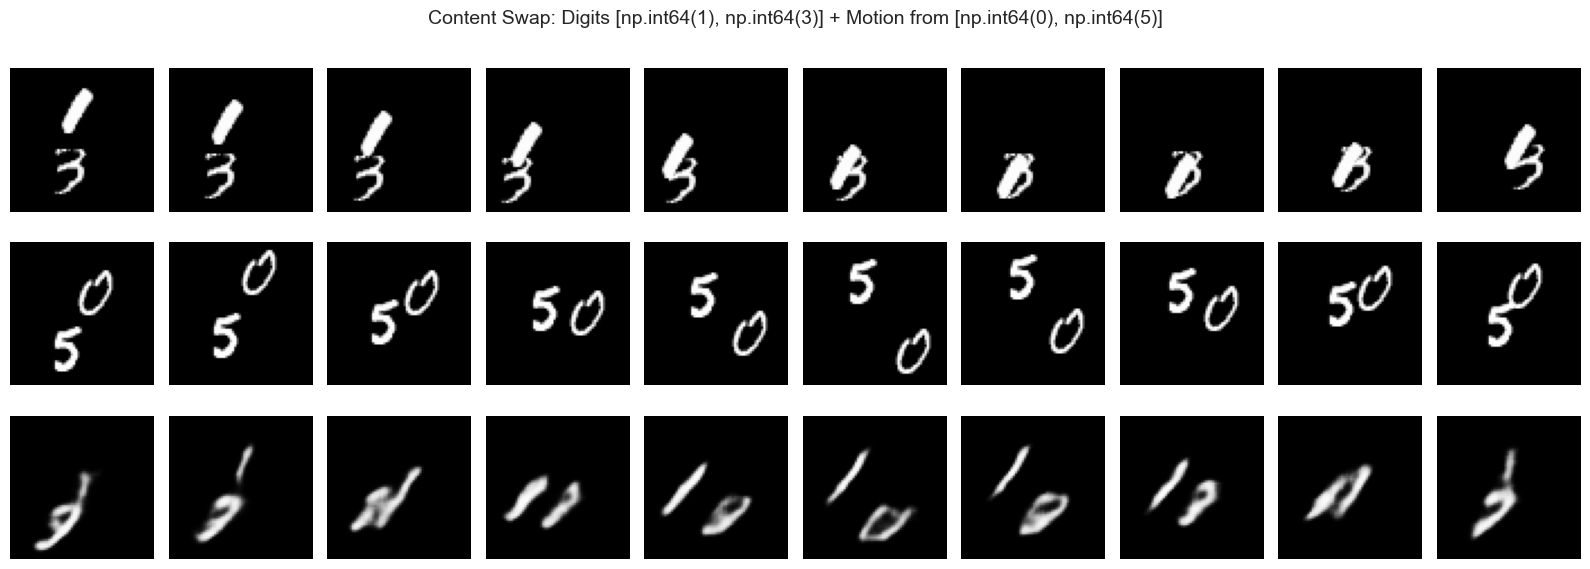


--- Swap 4 ---
Content source digits: [np.int64(5), np.int64(1)]
Motion source digits: [np.int64(5), np.int64(2)]
Expected result: Content source digits moving like motion source


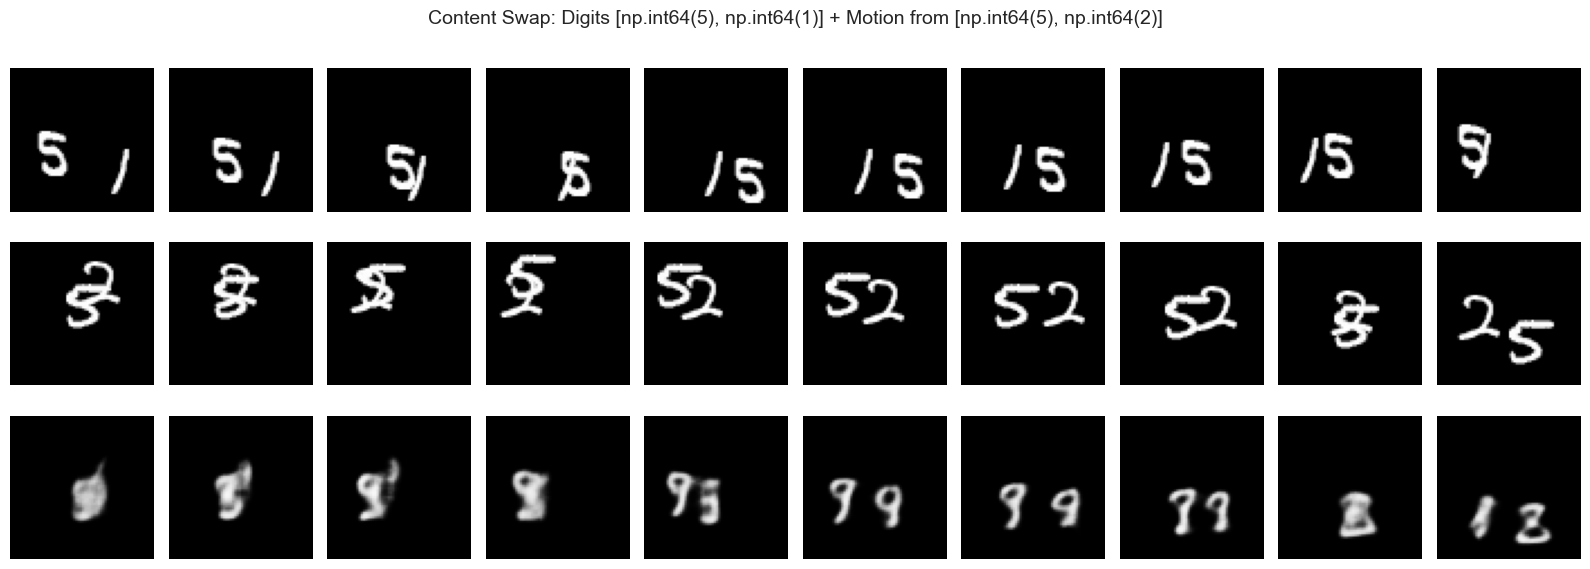

In [4]:
# Get sample videos
videos, metadata = next(iter(test_loader))
videos = videos.to(device)

# Perform multiple swap experiments
model.eval()
num_swaps = 4

for i in range(num_swaps):
    # Get two different videos
    idx_content = i * 2
    idx_motion = i * 2 + 1
    
    video_content = videos[idx_content:idx_content+1]
    video_motion = videos[idx_motion:idx_motion+1]
    
    # Get labels
    content_labels = metadata[idx_content]['labels']
    motion_labels = metadata[idx_motion]['labels']
    
    # Perform swap: content from A, motion from B
    with torch.no_grad():
        swapped = model.swap_content(video_content, video_motion)
    
    # Visualize
    print(f"\n--- Swap {i+1} ---")
    print(f"Content source digits: {content_labels}")
    print(f"Motion source digits: {motion_labels}")
    print("Expected result: Content source digits moving like motion source")
    
    fig = plot_swap_results(
        video_content, video_motion, swapped,
        title=f"Content Swap: Digits {content_labels} + Motion from {motion_labels}",
        num_frames=10
    )
    plt.savefig(f'../results/figures/swap_{i+1}.png', dpi=150, bbox_inches='tight')
    plt.show()


## 3. Evaluation Criteria

### Success Criteria for Content Swap:
1. **Digit Identity**: Swapped video should show the digits from the content source
2. **Motion Pattern**: Swapped video should follow the motion from the motion source
3. **Visual Quality**: Result should be clear and artifact-free

### Key Research Question:
Does explicit architectural separation enable better content/motion swapping compared to implicit methods?

### Expected Result:
The Disentangled VAE should successfully separate content and motion, allowing for clean swapping of these attributes between videos.
